# PySpark Window Functions

- To calculate results such as the rank, row number e.t.c over a range of input rows
- Operate on a group of rows (like frame, partition) and return a single value for every input row
- To perform an operation on a group first, we need to partition the data using Window.partitionBy() , and for row number and rank function we need to additionally order by on partition data using orderBy clause.

In [46]:
home = "/mnt"

bankData2015 = f"{home}/data/bank-customers.csv"

retailDataDay = f"{home}/data/retail-data/by-day/"
retailDataDaySmall = f"{home}/data/retail-data/by-day/2010-12-02.csv"

In [47]:
simpleData = (("James", "Sales", 3000), \
    ("Michael", "Sales", 4600),  \
    ("Robert", "Sales", 4100),   \
    ("Maria", "Finance", 3000),  \
    ("James", "Sales", 3000),    \
    ("Scott", "Finance", 3300),  \
    ("Jen", "Finance", 3900),    \
    ("Jeff", "Marketing", 3000), \
    ("Kumar", "Marketing", 2000),\
    ("Saif", "Sales", 4100) \
  )
 
columns= ["employee_name", "department", "salary"]
df = spark.createDataFrame(data = simpleData, schema = columns)
df.printSchema()
df.show(truncate=False)

root
 |-- employee_name: string (nullable = true)
 |-- department: string (nullable = true)
 |-- salary: long (nullable = true)

+-------------+----------+------+
|employee_name|department|salary|
+-------------+----------+------+
|James        |Sales     |3000  |
|Michael      |Sales     |4600  |
|Robert       |Sales     |4100  |
|Maria        |Finance   |3000  |
|James        |Sales     |3000  |
|Scott        |Finance   |3300  |
|Jen          |Finance   |3900  |
|Jeff         |Marketing |3000  |
|Kumar        |Marketing |2000  |
|Saif         |Sales     |4100  |
+-------------+----------+------+



In [48]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Specify the Window details
windowSpec  = Window.partitionBy("department").orderBy("salary")

# Use the window
df.withColumn("row_number",row_number().over(windowSpec)) \
    .show(truncate=False)

+-------------+----------+------+----------+
|employee_name|department|salary|row_number|
+-------------+----------+------+----------+
|James        |Sales     |3000  |1         |
|James        |Sales     |3000  |2         |
|Robert       |Sales     |4100  |3         |
|Saif         |Sales     |4100  |4         |
|Michael      |Sales     |4600  |5         |
|Maria        |Finance   |3000  |1         |
|Scott        |Finance   |3300  |2         |
|Jen          |Finance   |3900  |3         |
|Kumar        |Marketing |2000  |1         |
|Jeff         |Marketing |3000  |2         |
+-------------+----------+------+----------+



- rank() window function is used to provide a rank to the result within a window partition. This function leaves gaps in rank when there are ties.

In [49]:
from pyspark.sql.functions import rank
df.withColumn("rank",rank().over(windowSpec)) \
    .show()

+-------------+----------+------+----+
|employee_name|department|salary|rank|
+-------------+----------+------+----+
|        James|     Sales|  3000|   1|
|        James|     Sales|  3000|   1|
|       Robert|     Sales|  4100|   3|
|         Saif|     Sales|  4100|   3|
|      Michael|     Sales|  4600|   5|
|        Maria|   Finance|  3000|   1|
|        Scott|   Finance|  3300|   2|
|          Jen|   Finance|  3900|   3|
|        Kumar| Marketing|  2000|   1|
|         Jeff| Marketing|  3000|   2|
+-------------+----------+------+----+



- dense_rank() window function is used to get the result with rank of rows within a window partition without any gaps. This is similar to rank() function difference being rank function leaves gaps in rank when there are ties.

In [50]:
from pyspark.sql.functions import dense_rank
df.withColumn("dense_rank",dense_rank().over(windowSpec)) \
    .show()

+-------------+----------+------+----------+
|employee_name|department|salary|dense_rank|
+-------------+----------+------+----------+
|        James|     Sales|  3000|         1|
|        James|     Sales|  3000|         1|
|       Robert|     Sales|  4100|         2|
|         Saif|     Sales|  4100|         2|
|      Michael|     Sales|  4600|         3|
|        Maria|   Finance|  3000|         1|
|        Scott|   Finance|  3300|         2|
|          Jen|   Finance|  3900|         3|
|        Kumar| Marketing|  2000|         1|
|         Jeff| Marketing|  3000|         2|
+-------------+----------+------+----------+



## lag Window Function

In [51]:
from pyspark.sql.functions import lag    
df.withColumn("lag",lag("salary",2).over(windowSpec)) \
      .show()

+-------------+----------+------+----+
|employee_name|department|salary| lag|
+-------------+----------+------+----+
|        James|     Sales|  3000|null|
|        James|     Sales|  3000|null|
|       Robert|     Sales|  4100|3000|
|         Saif|     Sales|  4100|3000|
|      Michael|     Sales|  4600|4100|
|        Maria|   Finance|  3000|null|
|        Scott|   Finance|  3300|null|
|          Jen|   Finance|  3900|3000|
|        Kumar| Marketing|  2000|null|
|         Jeff| Marketing|  3000|null|
+-------------+----------+------+----+



## lead Window Function

In [52]:
from pyspark.sql.functions import lead    
df.withColumn("lead",lead("salary",2).over(windowSpec)) \
    .show()

+-------------+----------+------+----+
|employee_name|department|salary|lead|
+-------------+----------+------+----+
|        James|     Sales|  3000|4100|
|        James|     Sales|  3000|4100|
|       Robert|     Sales|  4100|4600|
|         Saif|     Sales|  4100|null|
|      Michael|     Sales|  4600|null|
|        Maria|   Finance|  3000|3900|
|        Scott|   Finance|  3300|null|
|          Jen|   Finance|  3900|null|
|        Kumar| Marketing|  2000|null|
|         Jeff| Marketing|  3000|null|
+-------------+----------+------+----+



In [57]:
windowSpecAgg  = Window.partitionBy("department")
from pyspark.sql.functions import col,avg,sum,min,max,row_number 
df.withColumn("row",row_number().over(windowSpec)) \
  .withColumn("avg", avg(col("salary")).over(windowSpecAgg)) \
  .withColumn("sum", sum(col("salary")).over(windowSpecAgg)) \
  .withColumn("min", min(col("salary")).over(windowSpecAgg)) \
  .withColumn("max", max(col("salary")).over(windowSpecAgg)) \
  .show()

+-------------+----------+------+---+------+-----+----+----+
|employee_name|department|salary|row|   avg|  sum| min| max|
+-------------+----------+------+---+------+-----+----+----+
|        James|     Sales|  3000|  1|3760.0|18800|3000|4600|
|        James|     Sales|  3000|  2|3760.0|18800|3000|4600|
|       Robert|     Sales|  4100|  3|3760.0|18800|3000|4600|
|         Saif|     Sales|  4100|  4|3760.0|18800|3000|4600|
|      Michael|     Sales|  4600|  5|3760.0|18800|3000|4600|
|        Maria|   Finance|  3000|  1|3400.0|10200|3000|3900|
|        Scott|   Finance|  3300|  2|3400.0|10200|3000|3900|
|          Jen|   Finance|  3900|  3|3400.0|10200|3000|3900|
|        Kumar| Marketing|  2000|  1|2500.0| 5000|2000|3000|
|         Jeff| Marketing|  3000|  2|2500.0| 5000|2000|3000|
+-------------+----------+------+---+------+-----+----+----+



## Another example

- Windows are more flexible than your normal groupBy in selecting your aggregate window

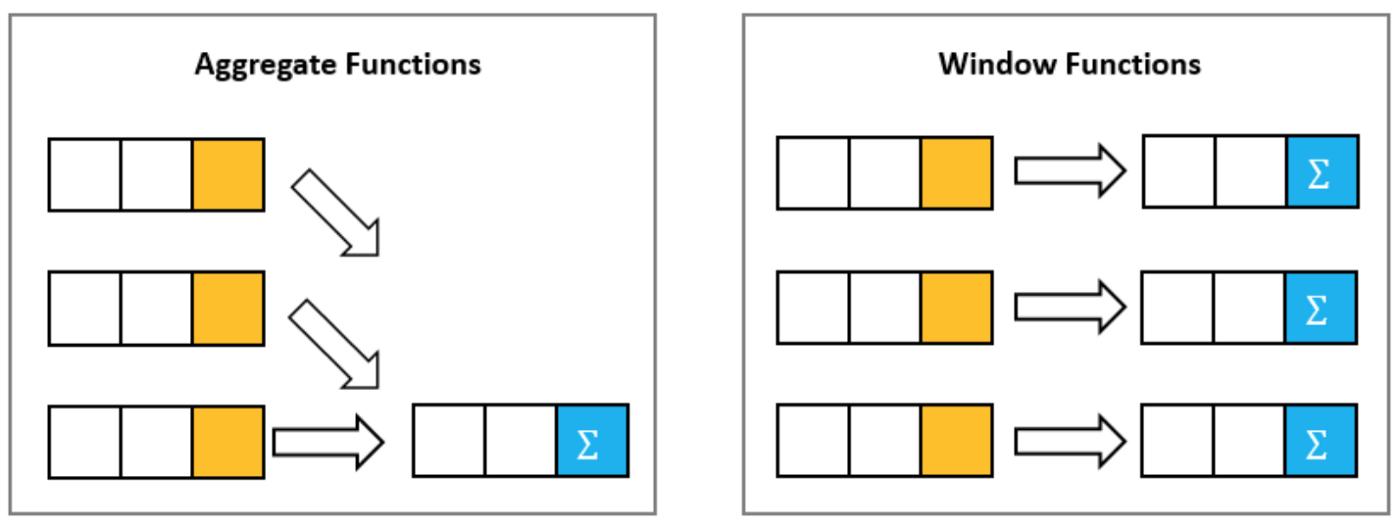

In [58]:
from pyspark import SQLContext,SparkConf,SparkContext,HiveContext
from pyspark.sql.window import Window
from pyspark.sql.types import DateType
import pyspark.sql.functions as F

In [59]:
shopping_data = \
[('Alex','2018-10-10','Paint',80),('Alex','2018-04-02','Ladder',20),('Alex','2018-06-22','Stool',20),\
('Alex','2018-12-09','Vacuum',40),('Alex','2018-07-12','Bucket',5),('Alex','2018-02-18','Gloves',5),\
('Alex','2018-03-03','Brushes',30),('Alex','2018-09-26','Sandpaper',10)]

In [60]:
df = spark.createDataFrame(shopping_data, ['name','date','product','price']).withColumn('date',F.col('date').cast(DateType()))

In [61]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- date: date (nullable = true)
 |-- product: string (nullable = true)
 |-- price: long (nullable = true)



In [62]:
df.show()

+----+----------+---------+-----+
|name|      date|  product|price|
+----+----------+---------+-----+
|Alex|2018-10-10|    Paint|   80|
|Alex|2018-04-02|   Ladder|   20|
|Alex|2018-06-22|    Stool|   20|
|Alex|2018-12-09|   Vacuum|   40|
|Alex|2018-07-12|   Bucket|    5|
|Alex|2018-02-18|   Gloves|    5|
|Alex|2018-03-03|  Brushes|   30|
|Alex|2018-09-26|Sandpaper|   10|
+----+----------+---------+-----+



## set the base Window Partition

In [63]:
w0 = Window.partitionBy('name')

## Moving Average and Running Sum of price

In [28]:
df.withColumn('avg_to_date',     F.round(F.avg('price').over(w0.orderBy(F.col('date'))),2))\
  .withColumn('accumulating_sum',F.sum('price').over(w0.orderBy(F.col('date'))))\
  .withColumn('max_to_date',     F.max('price').over(w0.orderBy(F.col('date'))))\
  .withColumn('max_of_last2',    F.max('price').over(w0.orderBy(F.col('date')).rowsBetween(-1,Window.currentRow)))\
  .withColumn('items_to_date',   F.count('*').over(w0.orderBy(F.col('date'))))\
  .show()

+----+----------+---------+-----+-----------+----------------+-----------+------------+-------------+
|name|      date|  product|price|avg_to_date|accumulating_sum|max_to_date|max_of_last2|items_to_date|
+----+----------+---------+-----+-----------+----------------+-----------+------------+-------------+
|Alex|2018-02-18|   Gloves|    5|        5.0|               5|          5|           5|            1|
|Alex|2018-03-03|  Brushes|   30|       17.5|              35|         30|          30|            2|
|Alex|2018-04-02|   Ladder|   20|      18.33|              55|         30|          30|            3|
|Alex|2018-06-22|    Stool|   20|      18.75|              75|         30|          20|            4|
|Alex|2018-07-12|   Bucket|    5|       16.0|              80|         30|          20|            5|
|Alex|2018-09-26|Sandpaper|   10|       15.0|              90|         30|          10|            6|
|Alex|2018-10-10|    Paint|   80|      24.29|             170|         80|        

## Time Lag and Lead for purchases

In [29]:
df.withColumn('days_from_last_purchase', F.datediff('date',F.lag('date',1).over(w0.orderBy(F.col('date')))))\
  .withColumn('days_before_next_purchase', F.datediff(F.lead('date',1).over(w0.orderBy(F.col('date'))),'date'))\
  .show()

+----+----------+---------+-----+-----------------------+-------------------------+
|name|      date|  product|price|days_from_last_purchase|days_before_next_purchase|
+----+----------+---------+-----+-----------------------+-------------------------+
|Alex|2018-02-18|   Gloves|    5|                   null|                       13|
|Alex|2018-03-03|  Brushes|   30|                     13|                       30|
|Alex|2018-04-02|   Ladder|   20|                     30|                       81|
|Alex|2018-06-22|    Stool|   20|                     81|                       20|
|Alex|2018-07-12|   Bucket|    5|                     20|                       76|
|Alex|2018-09-26|Sandpaper|   10|                     76|                       14|
|Alex|2018-10-10|    Paint|   80|                     14|                       60|
|Alex|2018-12-09|   Vacuum|   40|                     60|                     null|
+----+----------+---------+-----+-----------------------+-------------------